In [1]:
import phoebe
import numpy as np
logger = phoebe.logger(clevel='WARNING')

In [2]:
b = phoebe.default_binary()
b['requiv@primary'] = 1.35
b['requiv@secondary'] = 0.80
b['teff@primary'] = 6150
b['teff@secondary'] = 5680
b['q@orbit'] = 0.78
b['incl@orbit'] = 83.5

In [3]:
b.add_dataset('lc', times=phoebe.linspace(-0.6, 0.6, 241), passband='Johnson:V', dataset='ideal_lc', overwrite=True)

<ParameterSet: 78 parameters | contexts: constraint, compute, dataset, figure>

In [4]:
b.run_compute(irrad_method='none')

100%|██████████| 241/241 [00:06<00:00, 38.35it/s]


<ParameterSet: 3 parameters | qualifiers: times, fluxes, comments>

/usr/local/lib/python3.9/dist-packages/phoebe/dependencies/autofig/axes.py:1011: MatplotlibDeprecationWarning: 
The change_geometry function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use set_subplotspec instead.
  ax.change_geometry(rows, cols, i+1)
/usr/local/lib/python3.9/dist-packages/phoebe/dependencies/autofig/axes.py:1011: MatplotlibDeprecationWarning: 
The update_params function was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  ax.change_geometry(rows, cols, i+1)
/usr/local/lib/python3.9/dist-packages/phoebe/dependencies/autofig/axes.py:1011: MatplotlibDeprecationWarning: 
The figbox attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use get_subplotspec().get_position(self.figure) instead.
  ax.change_geometry(rows, cols, i+1)


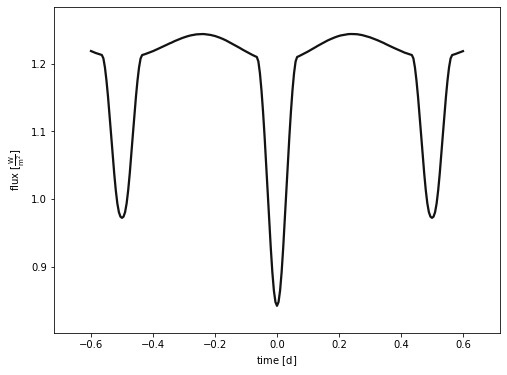

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [5]:
b.plot(show=True)

This is arguably quite a feature*ful* lightcurve, so let's see which parameters are well determined.

In [6]:
times = b['value@times@model@ideal_lc']
fluxes = b['value@fluxes@model@ideal_lc'] + np.random.normal(0, 0.01, size=241)
sigmas = np.ones_like(times)*0.01

In [7]:
b.add_dataset('lc', passband='Johnson:V', times=times, fluxes=fluxes, sigmas=sigmas, dataset='mock')

<ParameterSet: 45 parameters | contexts: constraint, compute, dataset, figure>

In [8]:
b.disable_dataset('ideal_lc')

<ParameterSet: 19 parameters | components: secondary, primary, binary>

In [9]:
b.run_compute(irrad_method='none')

Mon, 18 Apr 2022 22:57 BUNDLE       WARNING overwriting model: latest
100%|██████████| 241/241 [00:06<00:00, 39.37it/s]


<ParameterSet: 3 parameters | qualifiers: times, fluxes, comments>

/usr/local/lib/python3.9/dist-packages/phoebe/dependencies/autofig/axes.py:1011: MatplotlibDeprecationWarning: 
The change_geometry function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use set_subplotspec instead.
  ax.change_geometry(rows, cols, i+1)
/usr/local/lib/python3.9/dist-packages/phoebe/dependencies/autofig/axes.py:1011: MatplotlibDeprecationWarning: 
The update_params function was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  ax.change_geometry(rows, cols, i+1)
/usr/local/lib/python3.9/dist-packages/phoebe/dependencies/autofig/axes.py:1011: MatplotlibDeprecationWarning: 
The figbox attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use get_subplotspec().get_position(self.figure) instead.
  ax.change_geometry(rows, cols, i+1)


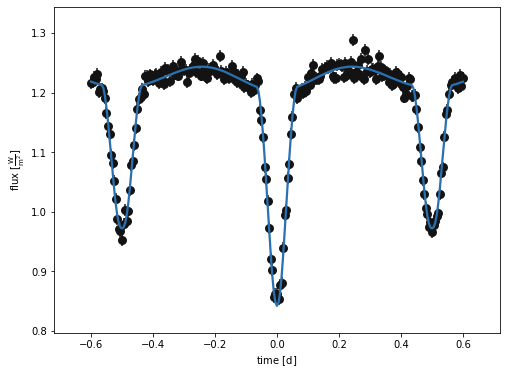

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [10]:
b.plot(show=True)

In [11]:
b.add_solver('optimizer.nelder_mead', solver='nms', maxfev=100, fatol=0.000241, overwrite=True)

Tue, 19 Apr 2022 00:26 BUNDLE       WARNING no valid parameters in fit_parameters  If not addressed, this warning will continue to be raised and will throw an error at run_solver.


<ParameterSet: 12 parameters | qualifiers: maxiter, fatol, priors, priors_combine, comments, fit_parameters, compute, maxfev, initial_values, expose_lnprobabilities, xatol, adaptive>

In [12]:
b['fit_parameters@nms'] = ['teff@primary', 'teff@secondary', 'pblum@primary']

In [13]:
b.run_solver('nms', solution='adjust_teffs')

  0%|          | 56/1000000 [08:10<2387:54:14,  8.60s/it]

<ParameterSet: 13 parameters | qualifiers: message, adopt_distributions, fitted_values, success, comments, adopt_parameters, initial_values, fitted_twigs, nfev, fitted_units, niter, adopt_values, fitted_uniqueids>

In [15]:
print(b['adjust_teffs'])

ParameterSet: 13 parameters
R  fitted_uniqueids@adjust_tef...: ['uyhACLuvkFDufzYzEbLjkmrWpQYXRA' 'DIeiVSOXhkLrfoyCUOXRiAucidTYRA'
 'FrKNsYOPsNbDwSoVwkYXeudzfswqpW' 'uIBncrZsHREXFocwsAEFsTVKdOKFny']
R  fitted_twigs@adjust_teffs@s...: ['teff@primary@star@component' 'teff@secondary@star@component'
 'pblum@primary@ideal_lc@lc@dataset' 'pblum@primary@mock@lc@dataset']
   adopt_parameters@adjust_tef...: ['teff@primary@star@component', 'teff@secondary@star@component', 'pblum@primary@ideal_lc@lc@dataset', 'pblum@primary@mock@lc@dataset']
   adopt_distributions@adjust_...: False
   adopt_values@adjust_teffs@s...: True
R   message@adjust_teffs@solution: Maximum number of function evaluations has been exceeded.
R      nfev@adjust_teffs@solution: 101
R     niter@adjust_teffs@solution: 57
R   success@adjust_teffs@solution: False
R  initial_values@adjust_teffs...: [6150.         5680.           12.56637061   12.56637061]
R  fitted_values@adjust_teffs@...: [6241.83643438 5747.8305952    12.69567216  

In [17]:
print(b['enabled'])

ParameterSet: 2 parameters
   enabled@ideal_lc@phoebe01@c...: False
    enabled@mock@phoebe01@compute: True
